In [9]:
from nilearn.connectome import ConnectivityMeasure
from brainspace.utils.parcellation import reduce_by_labels
import numpy as np
import os.path as op
from numrisk.fmri_analysis.gradients.utils import cleanTS, get_glasser_parcels
import seaborn as sns
import pandas as pd

import nilearn.plotting as nplt
import matplotlib.pyplot as plt

bids_folder = '/mnt_03/ds-dnumrisk' 

# group list
df_participants = pd.read_csv(op.join(bids_folder, 'add_tables','subjects_recruit_scan_scanned-final.csv'), header=0) #, index_col=0
group_list = df_participants.loc[:,['subject ID','group']].rename(mapper={'subject ID': 'subject'},axis=1).dropna().astype({'subject': int, 'group': int}).set_index('subject')

# Get Glasser parcellation and mask
from numrisk.fmri_analysis.gradients.utils import get_glasser_CAatlas_mapping, get_glasser_parcels
glasser_CAatlas_mapping, CAatlas_names = get_glasser_CAatlas_mapping()
mask_glasser, labeling_glasser = get_glasser_parcels(space = 'fsaverage5' )

from brainspace.utils.parcellation import map_to_labels
from nilearn.datasets import fetch_surf_fsaverage
fsaverage = fetch_surf_fsaverage()

from utils_01 import get_cleanTS_run, get_events_confounds
import statsmodels.api as sm

In [11]:
psy_context1 = 'stimulus1_int'
psy_context2 = 'stimulus2_int'
regressors_names = ['seedTS', 'psy_context1', 'psy_context2', 'seedTS:psy_context1', 'seedTS:psy_context2']
formula = 'targetTS ~ ' + ' + '.join(regressors_names)

seed_parcel = 275 - 1

beta_maps = []
tval_maps = []
for subject in range(1, 67):
    sub = f'{int(subject):02d}'
    # prep data
    DMs = []
    TSs = []
    for run in range(1, 7):
        try:
            dm = get_events_confounds(sub, ses=1, run=run, bids_folder=bids_folder)
            dm['run'] = run
            ts = get_cleanTS_run(sub, run=run, bids_folder=bids_folder)

            TSs.append(ts)
            DMs.append(dm)
        except:
            print(f'!!! ------ problems for run {run} (sub {sub} )')
    dm = pd.concat(DMs) # 1128 timesteps = 188 x 6
    dm.index.name = 'onset'
    dm.set_index('run',append=True,inplace=True)

    TSs = np.array(TSs)
    TSs = TSs.transpose(1, 0, 2).reshape(TSs.shape[1], (TSs.shape[0]*TSs.shape[2]))
    clean_ts = reduce_by_labels(TSs[mask_glasser], labeling_glasser[mask_glasser], axis=1, red_op='mean',dtype=float)

    #Fit model
    seedTS = clean_ts[seed_parcel]
    coef = {param: [] for param in regressors_names}
    tvals = {param: [] for param in regressors_names}
    for parcel_n in range(360):
        df_glm = pd.DataFrame(np.array([seedTS, clean_ts[parcel_n], dm[psy_context1], dm[psy_context2]]).T, columns = ['seedTS','targetTS','psy_context1', 'psy_context2'])
        result = sm.formula.ols(formula=formula, data=df_glm).fit()
        [tvals[param].append(result.tvalues[param]) for param in tvals.keys()]
        [coef[param].append(result.params[param]) for param in coef.keys()]

    beta_maps.append({key: np.array(value) for key, value in coef.items()})
    tval_maps.append({key: np.array(value) for key, value in tvals.items()})

# ~ 8 mins

A 'modulation' column was found in the given events data and is used.
Design matrix created to remove task effects. shape:
(188, 12)
A 'modulation' column was found in the given events data and is used.
Design matrix created to remove task effects. shape:
(188, 12)
A 'modulation' column was found in the given events data and is used.
Design matrix created to remove task effects. shape:
(188, 12)
A 'modulation' column was found in the given events data and is used.
Design matrix created to remove task effects. shape:
(188, 12)
A 'modulation' column was found in the given events data and is used.
Design matrix created to remove task effects. shape:
(188, 12)
A 'modulation' column was found in the given events data and is used.
Design matrix created to remove task effects. shape:
(188, 12)
A 'modulation' column was found in the given events data and is used.
Design matrix created to remove task effects. shape:
(188, 12)
A 'modulation' column was found in the given events data and is used.

In [17]:
# prep data 
data = []
for i in range(66):
    for param in regressors_names:
        data.append(tval_maps[i][param])

index = pd.MultiIndex.from_product([range(1, 67), regressors_names], names=['subject', 'regressor'])
df_params = pd.DataFrame(data, index=index, columns=[f'parcel_{i}' for i in range(1, 361)])
df = df_params.join(group_list).set_index('group',append=True)

tstat_cmap = 'bwr'
views = ['medial','lateral','dorsal','posterior']


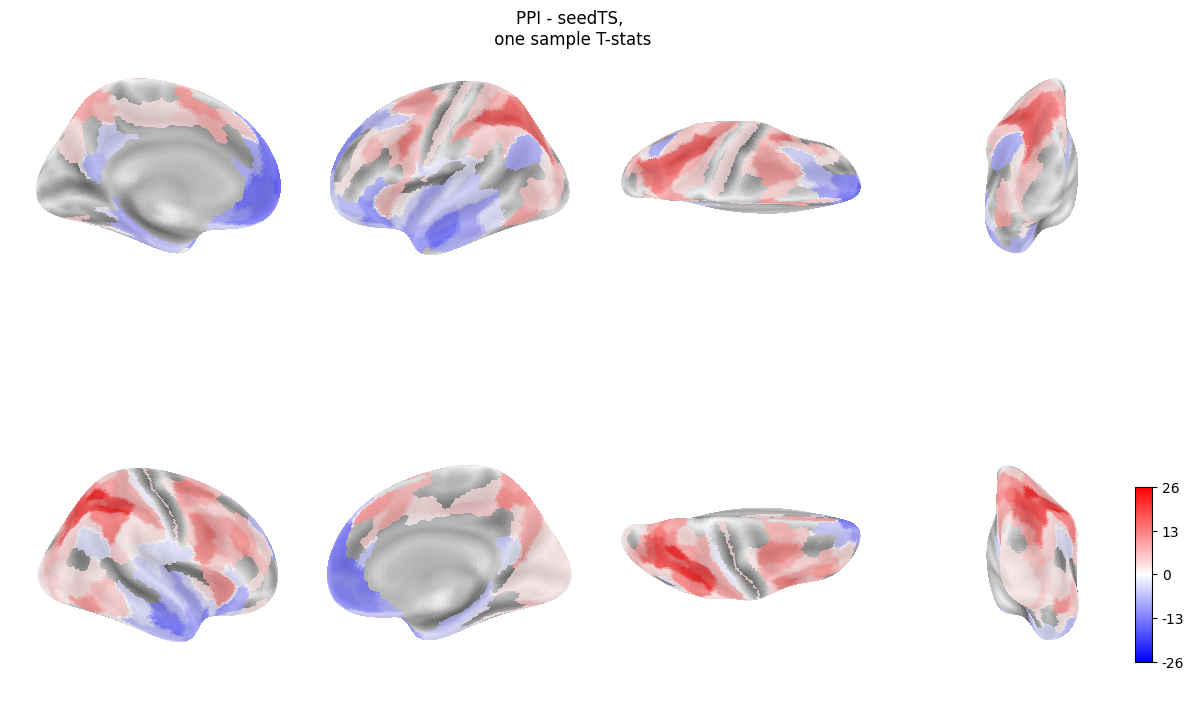

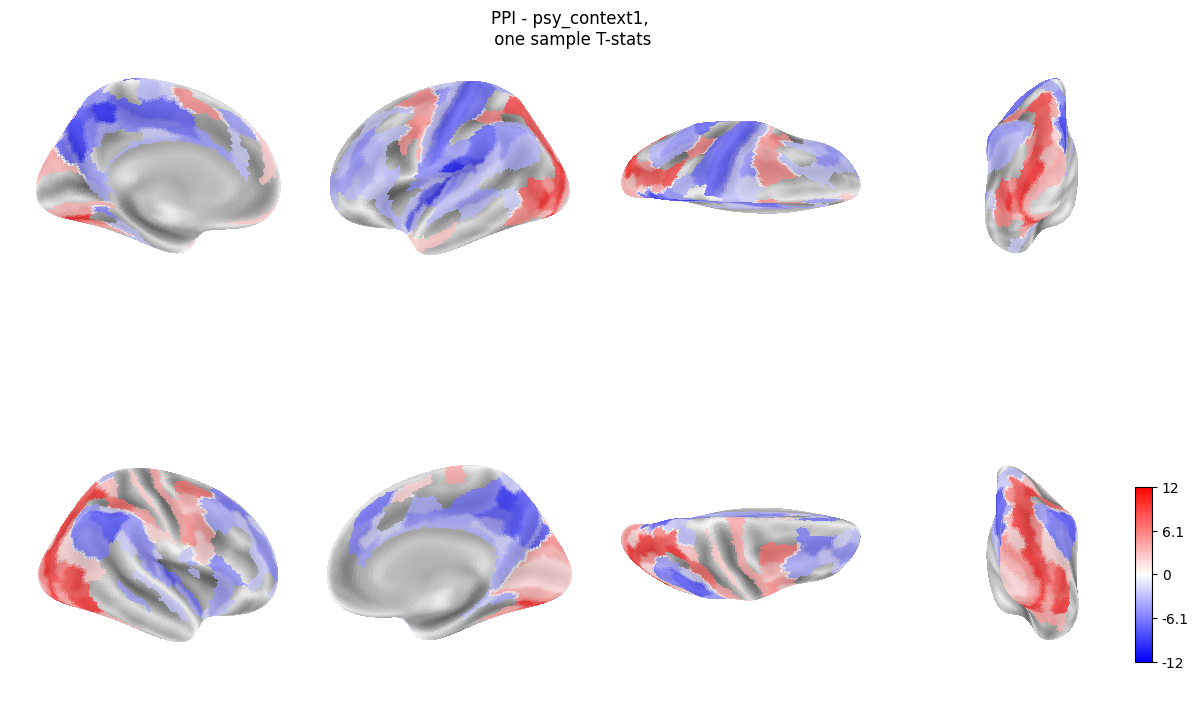

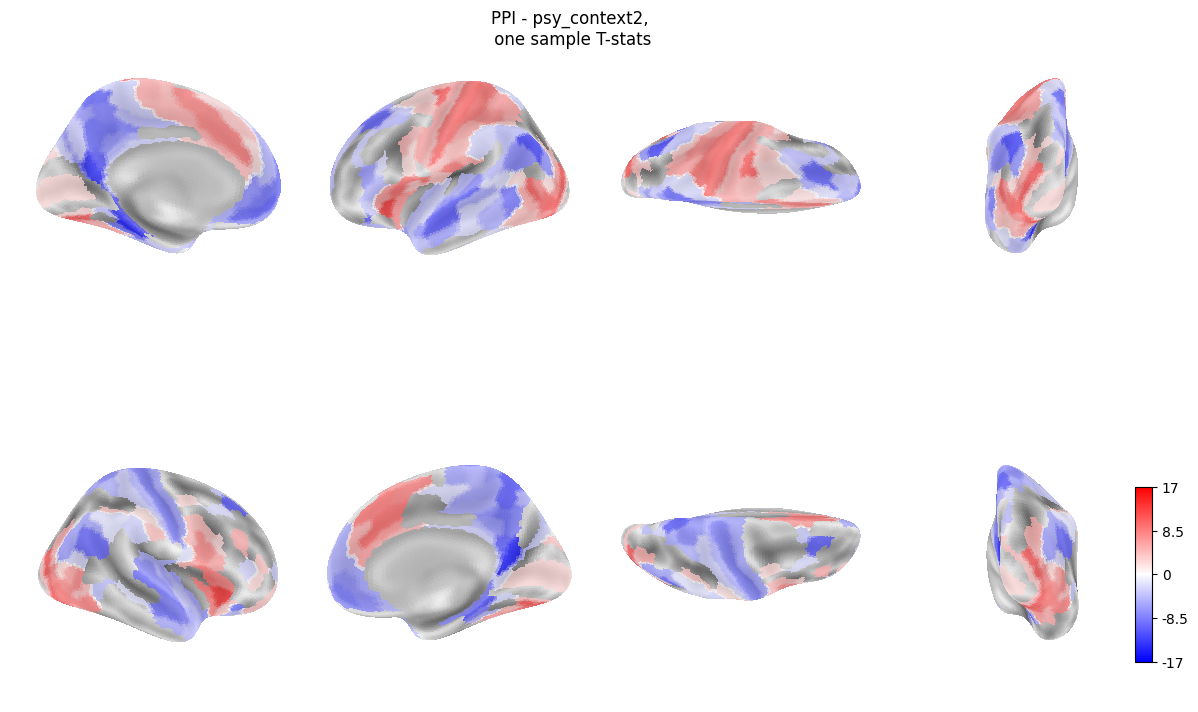

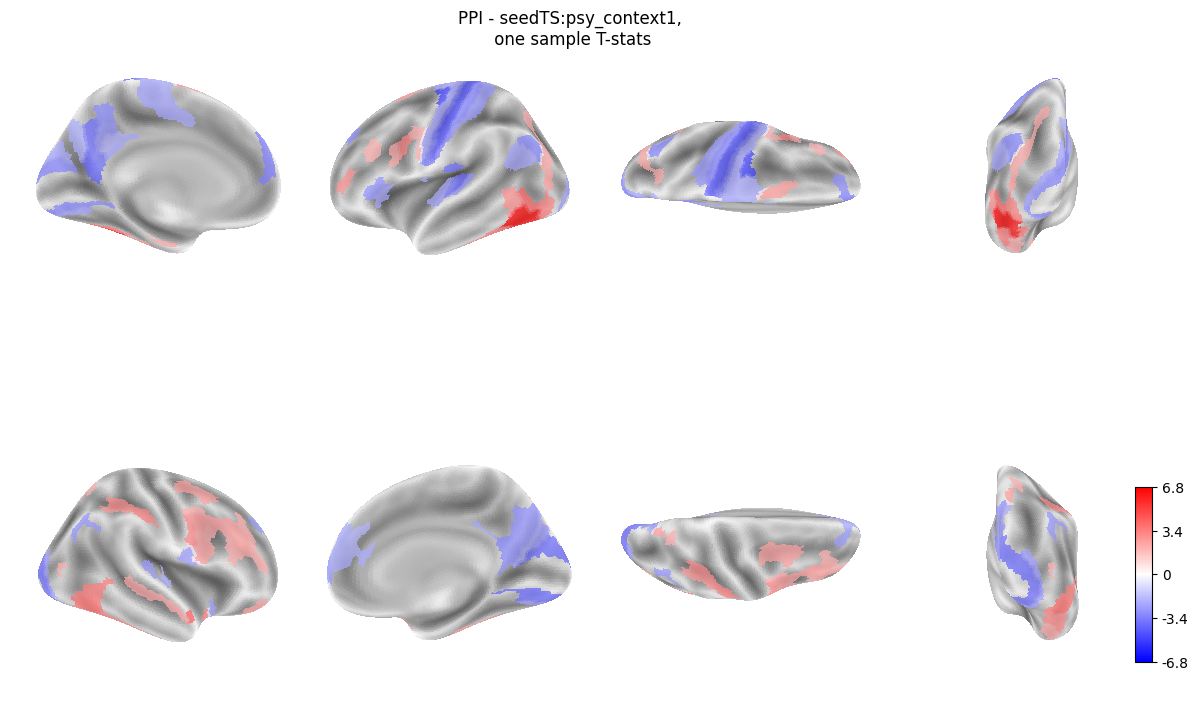

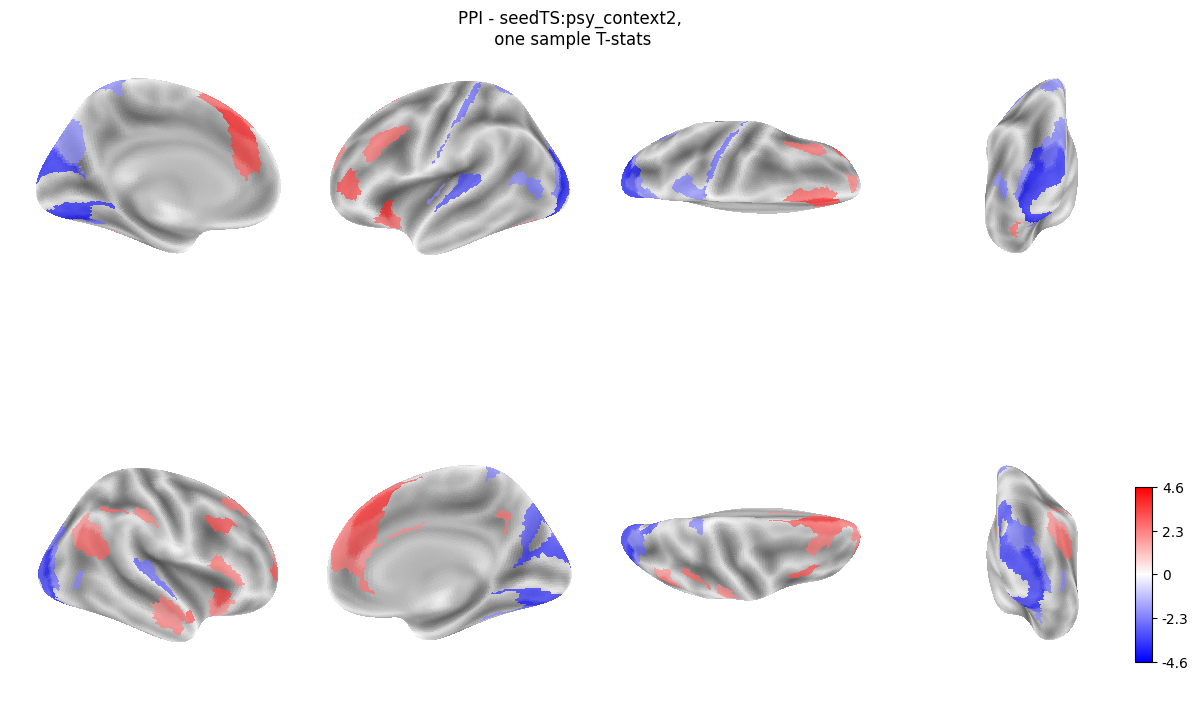

In [25]:
# one sample TTest

for param in regressors_names:
    tmp = df.xs(param,0,'regressor')
    t_stats, p_values = ttest_1samp(tmp, popmean=0, axis=0)

    stats_fsav5 = map_to_labels(t_stats, labeling_glasser, mask=mask_glasser, fill=np.nan) # parcel to vertex
    p_values_fsav5 = map_to_labels(p_values, labeling_glasser, mask=mask_glasser, fill=np.nan) # parcel to vertex
    stats_fsav5[p_values_fsav5 > 0.05] = np.nan

    figure, axes = plt.subplots(nrows=2, ncols=len(views),figsize = (15,10), subplot_kw=dict(projection='3d'))

    for j, hemi in enumerate(['L','R']):
        map = np.split(stats_fsav5,2)[j]
        surf_mesh = fsaverage.infl_right if hemi =='R' else fsaverage.infl_left
        bg_map = fsaverage.sulc_right if hemi =='R' else fsaverage.sulc_left
        Tval_extrem = np.max(np.abs(np.nan_to_num(stats_fsav5, nan=0.0, posinf=0.0, neginf=0.0)))
        for i,view in enumerate(views):
            colbar = True if view == 'posterior' and hemi == 'R' else False
            nplt.plot_surf(surf_mesh=surf_mesh , surf_map= map, vmin=-Tval_extrem, vmax=Tval_extrem,
                    view= view,cmap=tstat_cmap, colorbar=colbar, #title=f'sub-{sub}, grad {n_grad+1}',
                    bg_map=bg_map, bg_on_data=True,darkness=0.7, axes=axes[j,i]) 

    figure.subplots_adjust(wspace=0.01, hspace=0.01)
    figure.suptitle(f'PPI - {param}, \n one sample T-stats \n', y=0.85) # for p-val < 0.05
#figure.tight_layout()



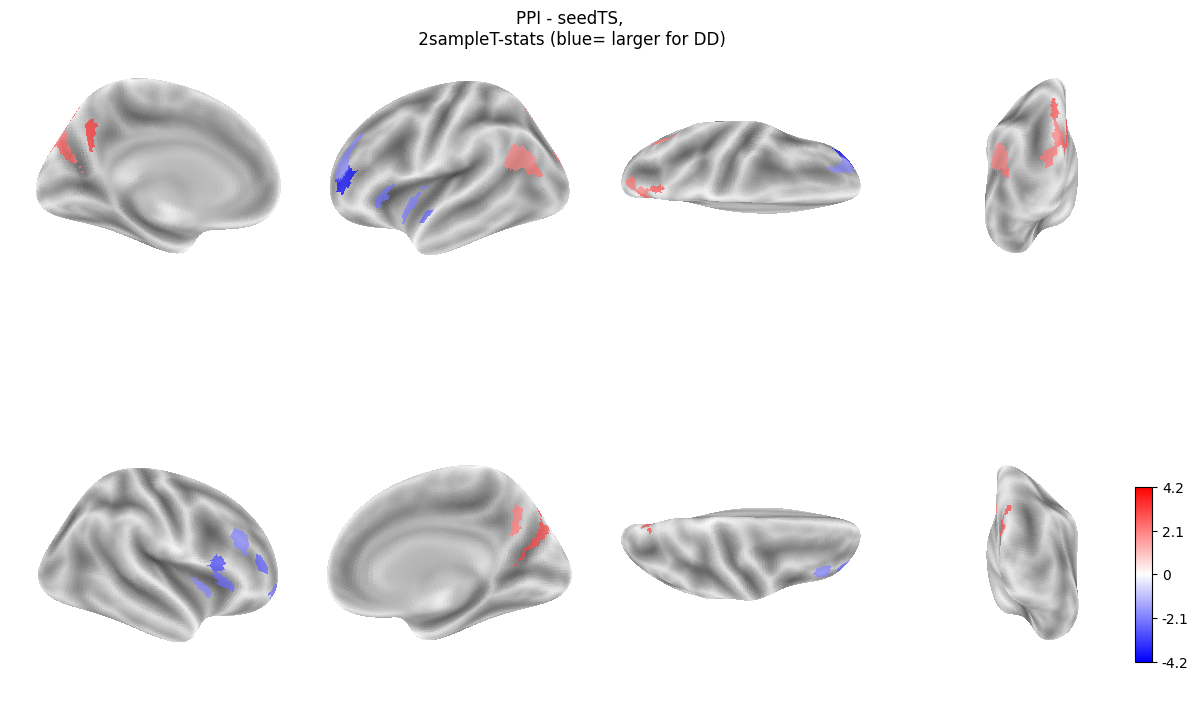

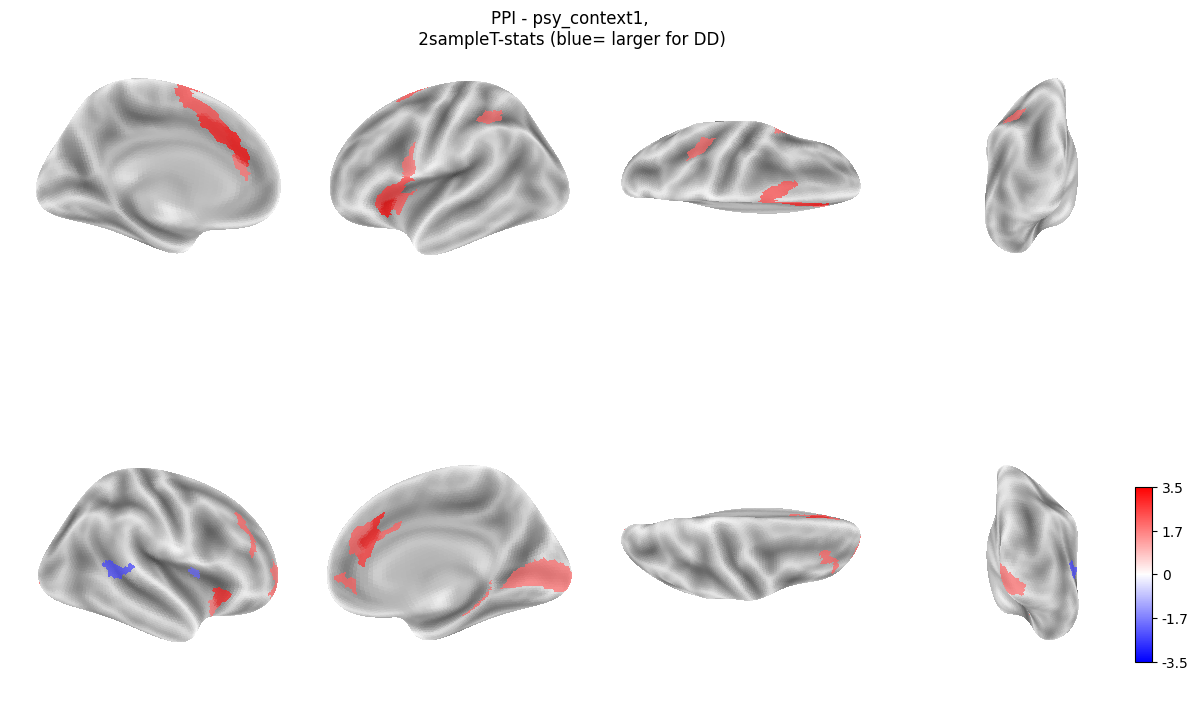

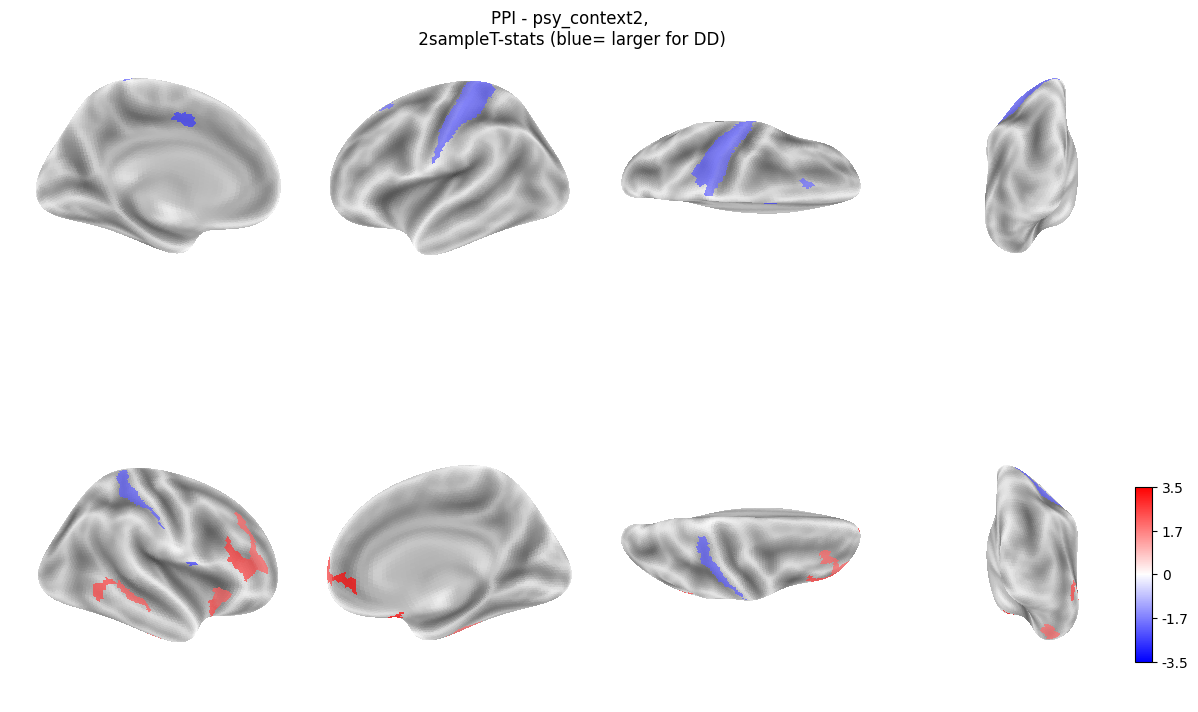

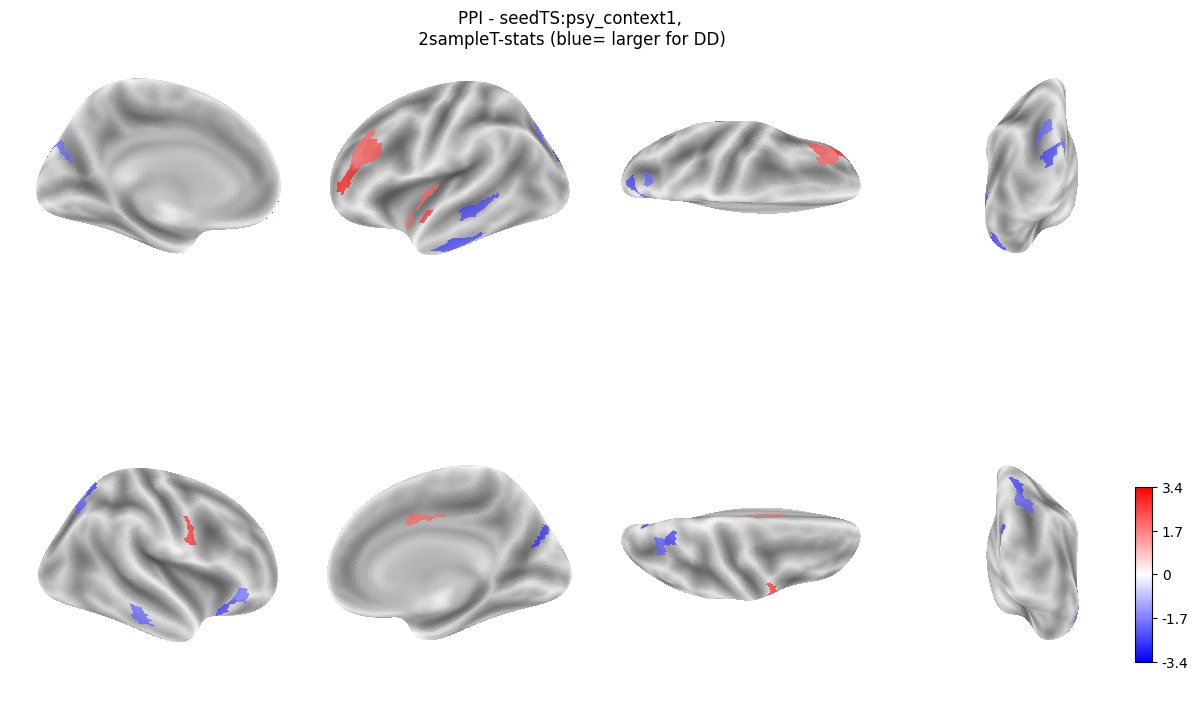

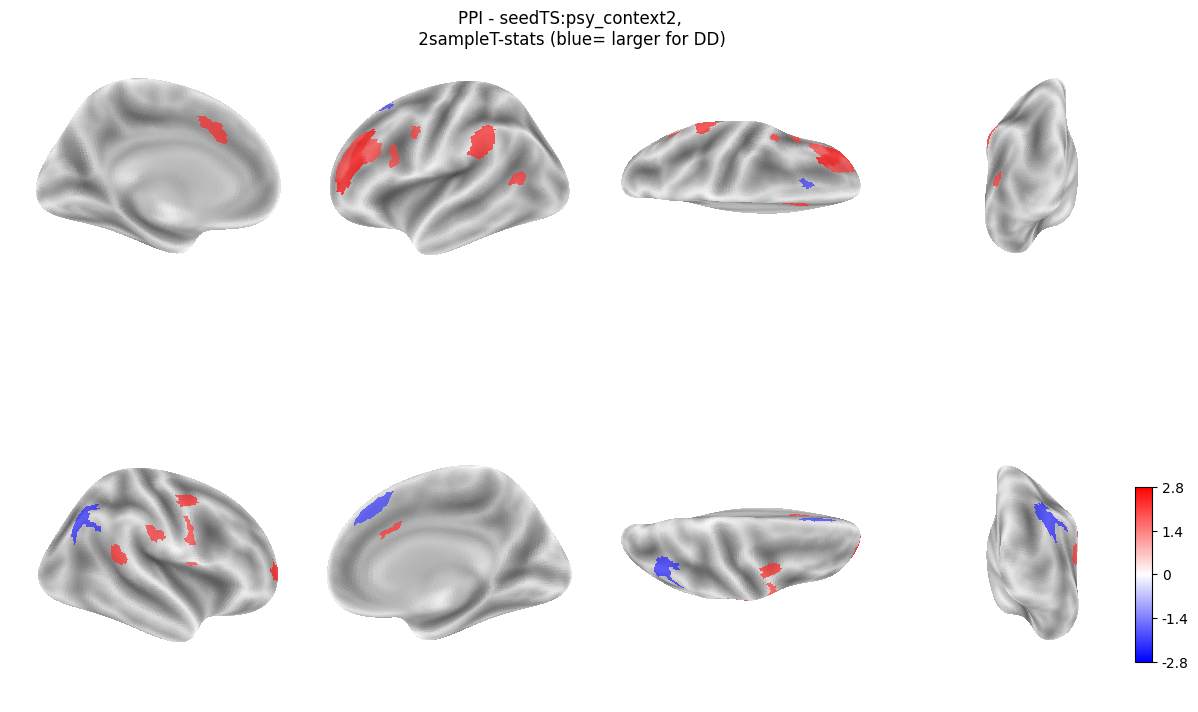

In [24]:
# 2 sample TTest

for param in regressors_names:
    tmp = df.xs(param,0,'regressor')
    group_0 = tmp.xs(0,0,'group')
    group_1 = tmp.xs(1,0,'group')

    t_stats, p_values = ttest_ind(group_0, group_1, axis=0, equal_var=False)    

    stats_fsav5 = map_to_labels(t_stats, labeling_glasser, mask=mask_glasser, fill=np.nan) # parcel to vertex
    p_values_fsav5 = map_to_labels(p_values, labeling_glasser, mask=mask_glasser, fill=np.nan) # parcel to vertex
    stats_fsav5[p_values_fsav5 > 0.05] = np.nan

    figure, axes = plt.subplots(nrows=2, ncols=len(views),figsize = (15,10), subplot_kw=dict(projection='3d'))

    for j, hemi in enumerate(['L','R']):
        map = np.split(stats_fsav5,2)[j]
        surf_mesh = fsaverage.infl_right if hemi =='R' else fsaverage.infl_left
        bg_map = fsaverage.sulc_right if hemi =='R' else fsaverage.sulc_left
        Tval_extrem = np.max(np.abs(np.nan_to_num(stats_fsav5, nan=0.0, posinf=0.0, neginf=0.0)))
        for i,view in enumerate(views):
            colbar = True if view == 'posterior' and hemi == 'R' else False
            nplt.plot_surf(surf_mesh=surf_mesh , surf_map= map, vmin=-Tval_extrem, vmax=Tval_extrem,
                    view= view,cmap=tstat_cmap, colorbar=colbar, #title=f'sub-{sub}, grad {n_grad+1}',
                    bg_map=bg_map, bg_on_data=True,darkness=0.7, axes=axes[j,i]) 

    figure.subplots_adjust(wspace=0.01, hspace=0.01)
    figure.suptitle(f'PPI - {param}, \n 2sampleT-stats (blue= larger for DD) \n', y=0.85) # for p-val < 0.05
#figure.tight_layout()

